In [1]:
import torch
import math
import numpy as np
dtype = torch.float
device = torch.device("cpu")
from matplotlib import pyplot as plt
import GPE_ensemble as GPE
import pandas as pd
import scipy
from  torch.distributions import normal

yobs = 8.0
sigma2 = 1.0


First we'll learn how to get the variational posterior for $x | y$ for a single value of y. We have
$$y= 4x-x^2/2+N(0,\sigma^2)$$

## Variational inference

Maximize the ELBO
$$ELBO(q) = E[\log p(y | x)] − KL (q(x)|| p(x)).$$

We'll use $q(x) = N(m, s^2)$ as the variational family
In this case, the ELBO can be computed exactly, but its a pain to do. So I've approximated the E[log p(y | x)] with a Monte Carlo sum.
$\Phi=(m, \log s^2)$ are the variational parameters


KL (q(x) || p(x)) = E[log q(x)] − E[log p(x)]
where expectations are with respect to q.

Note, if $p(x) \propto 1$, then $E\log p(x)$ does not depend on $\phi$ so can be ignored
If $q(x) =N(m, \sigma^2)$, then $E[\log q(x)] = -0.5 \log(2 \pi \sigma^2) - 1/2$

0


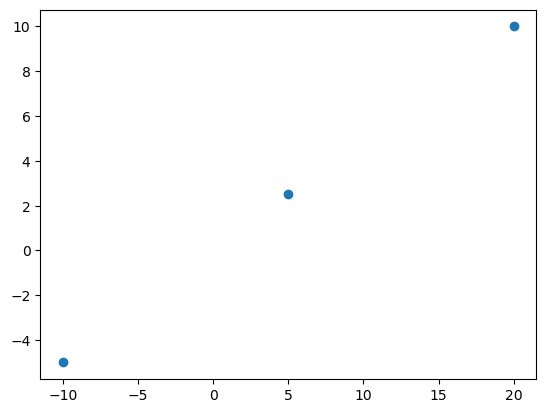

In [2]:
p=3

rl = -10
ru=20

obs_error = 0.0001

x=torch.linspace(rl,ru,p)

b=0.5

def lin(x):
    y = b*x
    return y

y = lin(x) 

plt.plot(x[:,None],y[:,None],'o')

emulator = GPE.ensemble(x[:,None],y[:,None],mean_func="constant",training_iter=500)

In [3]:
x.shape

torch.Size([3])

In [4]:
def ELBO(m,log_s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    param=[m,log_s2]
    L=torch.zeros((x.shape[0],x.shape[0]))
    mu = torch.tensor((param[0:x.shape[0]]))
    L=L.diagonal_scatter(torch.exp(torch.tensor(param[x.shape[0]:2*x.shape[0]])),0)
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = torch.matmul(L,L.T)
    z=x*torch.exp(log_s2/2.)+m
    
    z=z.T
    
    mc_int = torch.sum(emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+torch.log(x_prior(z,prior_mean,prior_cov)).squeeze())
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int/x.shape[1] - q_prior(covar)
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = normal.Normal(loc=mean, scale=torch.sqrt(cov))
    val = torch.exp(dist.log_prob(x))
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(2*np.pi)-0.5*torch.log(sigma2)
    return likelihood_manual

In [5]:
def KL(log_var):   
    return(-0.5*np.log(2.0*math.pi)-0.5*log_var-0.5)

def f(x):
    return(4.*x-0.5*torch.pow(x,2.))
# How do we define functions? x needs declaring?




def ZtoX(m, log_s2):
    #reparameterization trick
    return(Z*torch.exp(log_s2/2.)+m)


In [6]:

def log_dnorm(x, mean, var):
    return(-(x-mean).pow(2)/(2.*var)-0.5*np.log(2*math.pi*var))
    # checked - could used built-in torch dnorm



def Eloglike(m,log_s2):
    X= ZtoX(m, log_s2)
    
    #print(X)
    #Rewrite with f
    loglikes = log_dnorm(f(X), yobs, sigma2) # observation likelihood
    #-(yobs- 4.*X+0.5*X.pow(2)).pow(2)    #f(ZtoX(phi)),2.)
    
    return(loglikes.mean())



In [9]:
prior_mean=torch.tensor([0])
prior_cov = torch.tensor([5])
obs_error = [0.001]
y_cal = torch.tensor([5])

In [10]:
### initialize the variational parameters
m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
log_s2 = torch.full((),torch.log(torch.tensor(3.)), requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)


learning_rate = 1e-2
for t in range(10000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    param = [m,log_s2]
    
    negELBO = ELBO(m,log_s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m.item(), 's2=', log_s2.exp().item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m -= learning_rate * m.grad
        log_s2 -= learning_rate * log_s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        log_s2.grad = None
        
print(f'Result: p(x|y) = N({m.item()}, {log_s2.exp().item()}) ')

99 2.8766777515411377 m= 0.9844983220100403 s2= 2.2797038555145264
199 3.0669758319854736 m= 0.9722641110420227 s2= 1.8312894105911255
299 3.1957321166992188 m= 0.9620619416236877 s2= 1.5320378541946411
399 3.3158960342407227 m= 0.9558230042457581 s2= 1.3158869743347168
499 3.4415552616119385 m= 0.9504829049110413 s2= 1.152732253074646
599 3.535385847091675 m= 0.9469984769821167 s2= 1.0259919166564941
699 3.6239750385284424 m= 0.9438668489456177 s2= 0.9247155785560608
799 3.712885618209839 m= 0.9410999417304993 s2= 0.8409972190856934
899 3.784090042114258 m= 0.938062846660614 s2= 0.7718473076820374
999 3.8597540855407715 m= 0.9367544054985046 s2= 0.7134897112846375
1099 3.9320387840270996 m= 0.9363154172897339 s2= 0.6628971695899963
1199 3.9943065643310547 m= 0.9352058172225952 s2= 0.618865430355072
1299 4.053172588348389 m= 0.9343660473823547 s2= 0.5801464915275574
1399 4.113320350646973 m= 0.9333866834640503 s2= 0.5460652112960815
1499 4.163685321807861 m= 0.9335227012634277 s2= 0.51

In [11]:
emulator.predict(torch.tensor([1]))

tensor([[0.3021]], grad_fn=<PermuteBackward0>)

In [12]:
L=torch.zeros((Z.shape[0],Z.shape[0]))
mu = torch.tensor((param[0:Z.shape[0]]))
L=L.diagonal_scatter(torch.exp(torch.tensor(param[Z.shape[0]:2*Z.shape[0]])),0)

In [13]:
torch.matmul(L,Z)

tensor([[-1.6902e-01, -7.8390e-02,  1.9252e-02,  8.4543e-02, -2.9563e-02,
         -1.2193e-01, -1.2735e-02, -8.1446e-02,  1.4524e-01, -1.1641e-03,
          7.2323e-04,  2.0618e-01, -2.5473e-02, -6.3508e-02, -2.5142e-01,
         -9.1510e-02, -7.6487e-02,  1.6342e-02, -5.8277e-02, -1.0450e-01,
         -7.6469e-03,  5.1650e-02,  9.6047e-02,  9.2795e-02, -7.0829e-02,
         -9.3541e-02, -6.5685e-02, -1.1591e-01,  2.3420e-01, -1.1230e-01,
          9.6154e-02, -2.2965e-01,  2.2371e-02, -1.1755e-01,  3.1745e-02,
         -1.1460e-02, -2.5707e-02,  3.2531e-02,  4.7599e-02,  1.1635e-01,
          6.7554e-02, -6.2333e-02,  3.2078e-02, -2.1503e-02, -1.6439e-02,
          5.0331e-02,  6.9731e-02,  3.4559e-02, -4.5909e-02,  1.1800e-01,
         -3.9206e-02, -6.2267e-03,  8.7649e-02,  1.6487e-01, -2.8042e-02,
          4.9866e-03, -5.1931e-02, -1.3192e-01, -5.3519e-02, -6.8285e-02,
         -8.6206e-02,  7.5825e-02,  6.0224e-02, -2.6993e-02, -9.0382e-02,
         -6.1726e-02,  1.2962e-01,  3.

In [14]:
log_s2.grad

Next steps

- amortized inference
- Can we use GPtorch as function?
- write as a class with a fwd and backward method
- use torch.nn class to define params?
- use random Z at each stage? Should the number of samples increase as we converge?
- add prior for x
- change f to avoid bimodal posterior.

## Amortized Variational Inference

Let's assume $q(x|y)$ can be modelled as $N(m(y), s2(y))$ where $m(y)$ and $s2(y)$ are both modelled as neural networks.


